# Base EDA

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir('train'))

# Any results you write to the current directory are saved as output.

['lpmt_pos.csv', 'spmt_pos.csv', 'train_info.csv', 'train_lpmt_hits.h5', 'train_lpmt_n_hits.csv', 'train_spmt_hits.h5', 'train_spmt_n_hits.csv']


In [3]:
# import libs
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
import os
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
%%time
train_lpmt_hits = pd.read_hdf('train/train_lpmt_hits.h5')
train_spmt_n_hits = pd.read_csv('train/train_spmt_n_hits.csv')
train_info = pd.read_csv('train/train_info.csv')
train_spmt_hits = pd.read_hdf('train/train_spmt_hits.h5')
train_lpmt_n_hits = pd.read_csv('train/train_lpmt_n_hits.csv')
spmt_pos = pd.read_csv('train/spmt_pos.csv')
lpmt_pos = pd.read_csv('train/lpmt_pos.csv')

CPU times: user 148 ms, sys: 2.23 s, total: 2.38 s
Wall time: 2.97 s


In [5]:
train_lpmt_n_hits.rename(columns={"event_id": "event"}, inplace=True)
train_spmt_n_hits.rename(columns={"event_id": "event"}, inplace=True)
train_lpmt_hits.rename(columns={'pmtID': "pmt_id"}, inplace=True)
train_spmt_hits.rename(columns={'pmtID': "pmt_id"}, inplace=True)

In [6]:
%%time
tmp1 = pd.merge(train_lpmt_n_hits,train_lpmt_hits, how = 'inner', on = 'event')
lpmt = pd.merge(tmp1,lpmt_pos,on = 'pmt_id',how = 'inner')

CPU times: user 40.2 s, sys: 11.9 s, total: 52.1 s
Wall time: 52 s


In [7]:
lpmt['is_DN'] = lpmt.isDN.apply(lambda x: 1 if x == True else 0)

In [8]:
event_dn_me = lpmt.groupby('event', as_index = False)['is_DN'].mean()
pmt_dn_me = lpmt.groupby('pmt_id', as_index = False)['is_DN'].mean()

In [9]:
event_dn_me['isDN_me'] = event_dn_me.is_DN.apply(lambda x: round(x,2))
pmt_dn_me['isDN_me'] = pmt_dn_me.is_DN.apply(lambda x: round(x,3))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

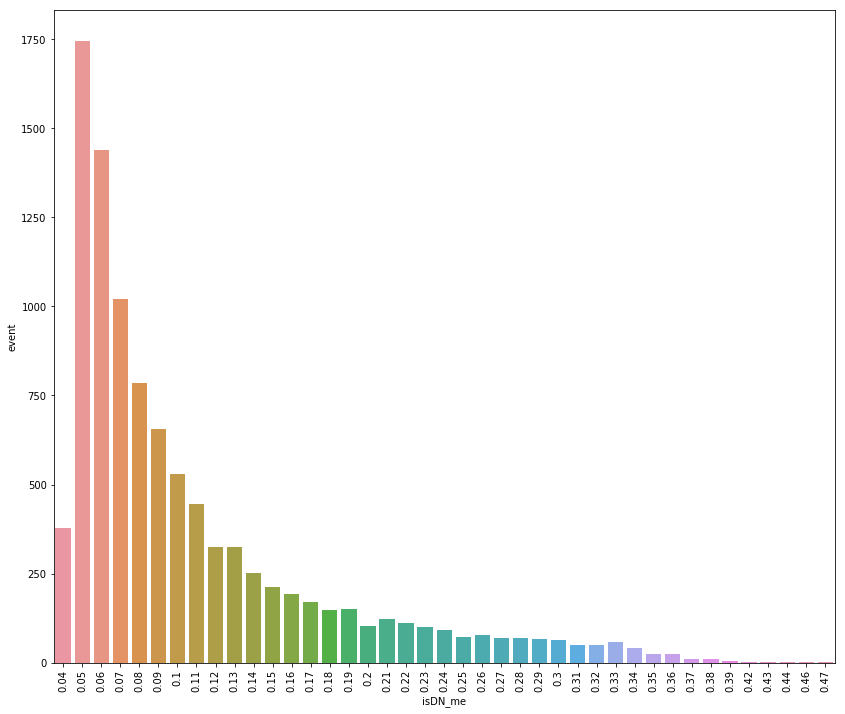

In [10]:
#Посомтрим распределение шума внутри каждого ивэнта
plt.figure(figsize=(14,12))
sns.barplot(x="isDN_me", y="event", data=event_dn_me.groupby('isDN_me', as_index = False)['event'].count())
plt.xticks(rotation=90)
#plt.xticks(x, labels, rotation='vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 <a list of 66 Text xticklabel objects>)

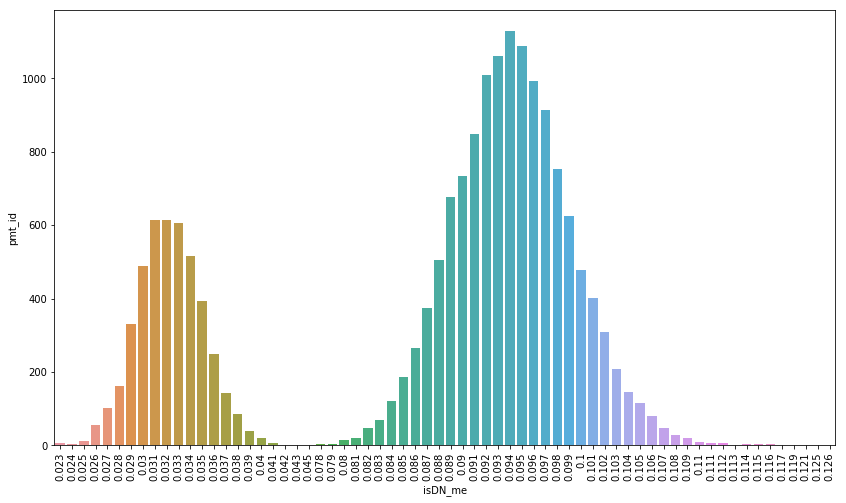

In [11]:
#Доля шума внутри каждого детектора
plt.figure(figsize=(14,8))
sns.barplot(x="isDN_me", y="pmt_id", data=pmt_dn_me.groupby('isDN_me', as_index = False)['pmt_id'].count())
plt.xticks(rotation=90)
#plt.xticks(x, labels, rotation='vertical')
# Судя по всему вероятность шума в детекторе равно 2 нормальным распределениям (:
# Разделим детекторы на 2 класса (из распределения 1 и из распределеня 2)

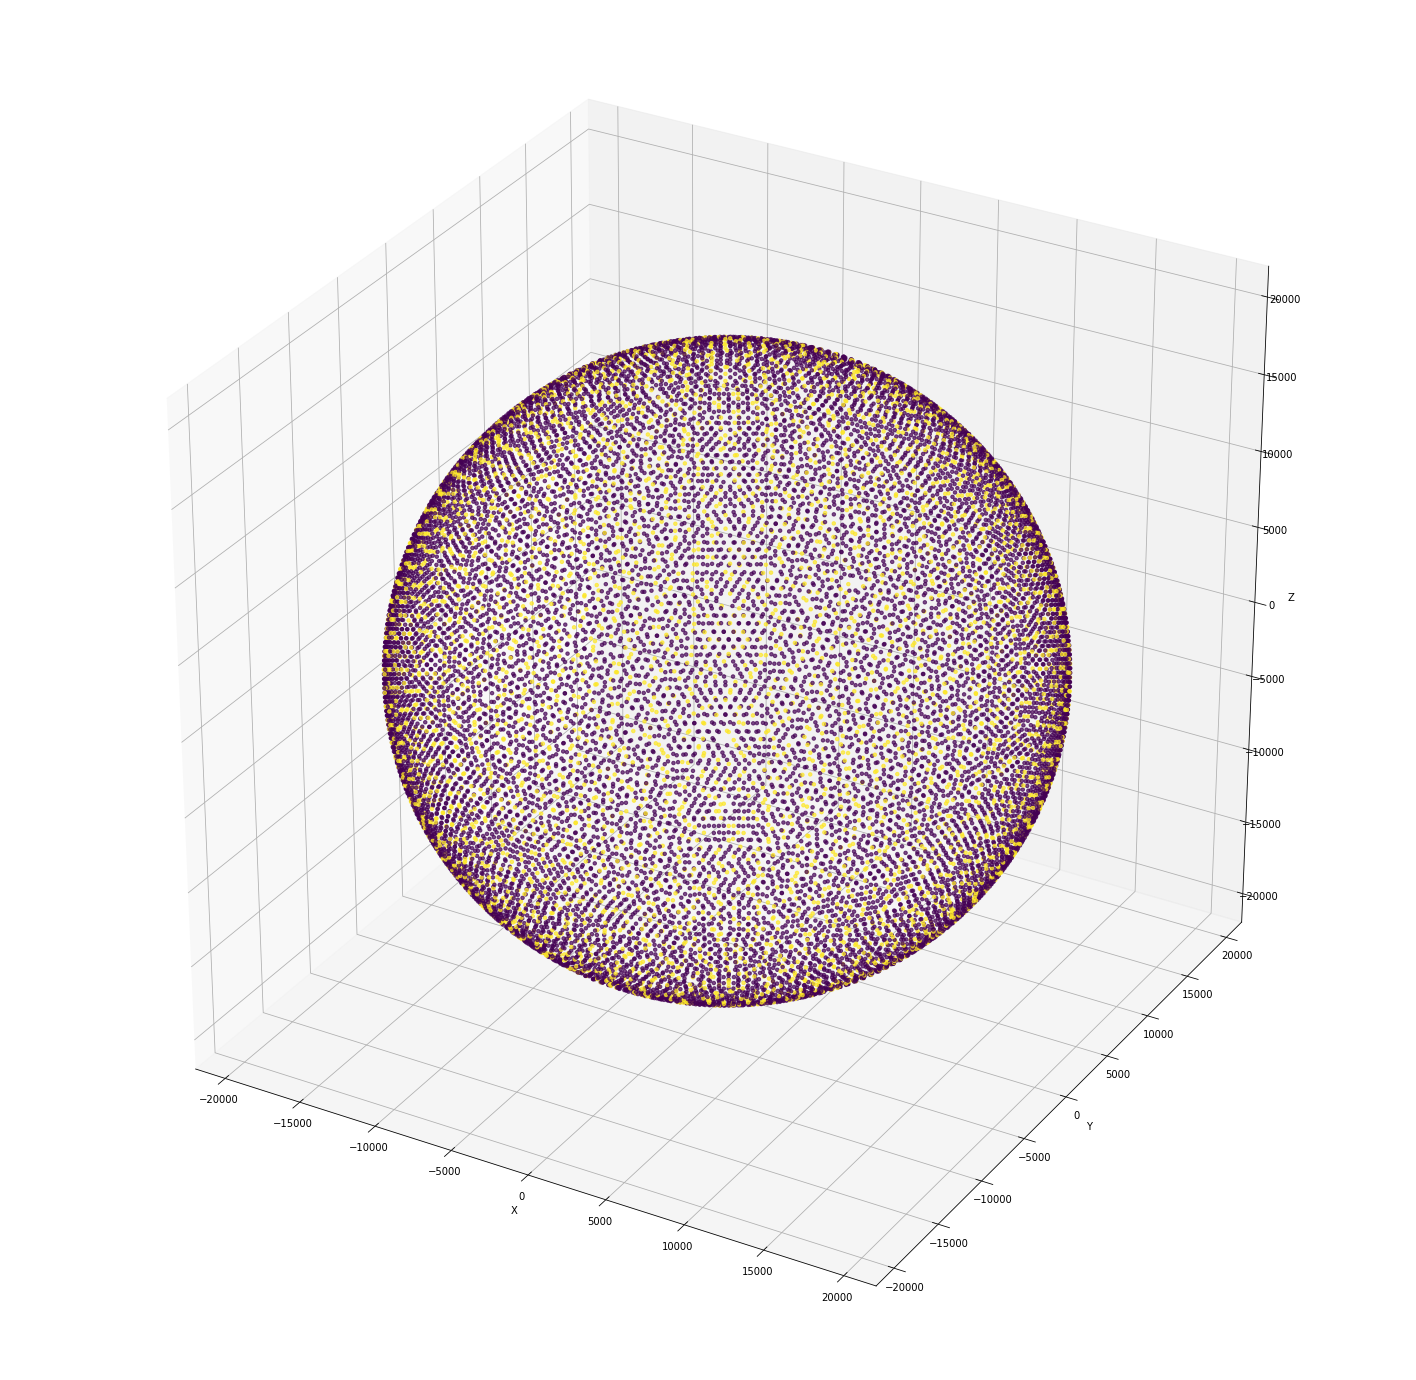

In [12]:
#Посмотрим как расположены детекторы классов 1 и 2 в пространсве
pmt_dn_me['color'] = pmt_dn_me.isDN_me.apply(lambda x: 1 if x < 0.044 else 0)
gr = pd.merge(lpmt_pos,pmt_dn_me,on='pmt_id',how='inner')
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

x = gr['pmt_x']
y = gr['pmt_y']
z = gr['pmt_z']

ax.scatter(x, y, z,c = pmt_dn_me['color'], marker='o', s=12, alpha=0.7)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
# детекторы распределены равномерно в пространстве

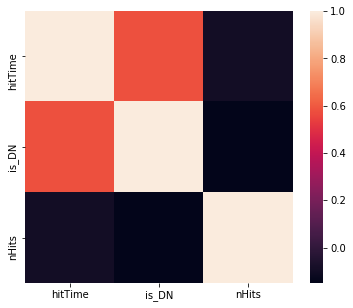

In [13]:
#Корреляция времени с шумом и количеством детектирований
plt.figure(figsize=(6,5))
sns.heatmap(lpmt[['hitTime','is_DN','nHits']].corr())

In [26]:
data_color_1_is_DN_1 = pd.merge(lpmt[lpmt.isDN == 1],pmt_dn_me[pmt_dn_me.color == 1],on='pmt_id',how = 'inner')
data_color_1_is_DN_0 = pd.merge(lpmt[lpmt.isDN == 0],pmt_dn_me[pmt_dn_me.color == 1],on='pmt_id',how = 'inner')
data_color_0_is_DN_1 = pd.merge(lpmt[lpmt.isDN == 1],pmt_dn_me[pmt_dn_me.color == 0],on='pmt_id',how = 'inner')
data_color_0_is_DN_0 = pd.merge(lpmt[lpmt.isDN == 0],pmt_dn_me[pmt_dn_me.color == 0],on='pmt_id',how = 'inner')

In [27]:
data_color_1_is_DN_1.shape

(710885, 12)

In [28]:
data_color_1_is_DN_0.shape

(21328855, 12)

In [29]:
data_color_0_is_DN_1.shape

(6653185, 12)

In [30]:
data_color_0_is_DN_0.shape

(64024078, 12)

In [31]:
data_color_1_is_DN_1['ht'] = data_color_1_is_DN_1.hitTime.apply(lambda x: round(x))
data_color_1_is_DN_0['ht'] = data_color_1_is_DN_0.hitTime.apply(lambda x: round(x))
data_color_0_is_DN_1['ht'] = data_color_0_is_DN_1.hitTime.apply(lambda x: round(x))
data_color_0_is_DN_0['ht'] = data_color_0_is_DN_0.hitTime.apply(lambda x: round(x))

In [32]:
gr11 = data_color_1_is_DN_1.groupby('ht',as_index =False)['pmt_id'].count()
gr10 = data_color_1_is_DN_0.groupby('ht',as_index =False)['pmt_id'].count()
gr01 = data_color_0_is_DN_1.groupby('ht',as_index =False)['pmt_id'].count()
gr00 = data_color_0_is_DN_0.groupby('ht',as_index =False)['pmt_id'].count()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

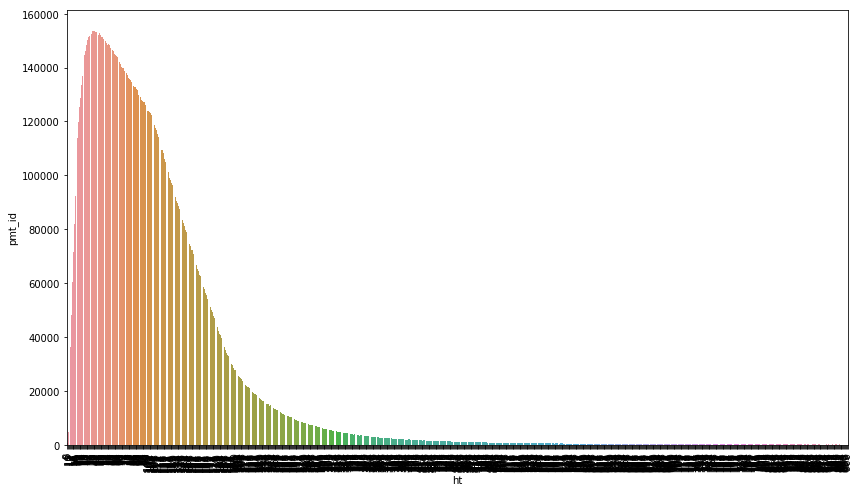

In [33]:
#Распределение времени отклика для нешумовых событий в детекторах класса 1
plt.figure(figsize=(14,8))
sns.barplot(x="ht", y="pmt_id", data=gr10)
plt.xticks(rotation=90)
# они приходят к нам из гамма распределения

(array([   0,    1,    2, ...,  998,  999, 1000]),
 <a list of 1001 Text xticklabel objects>)

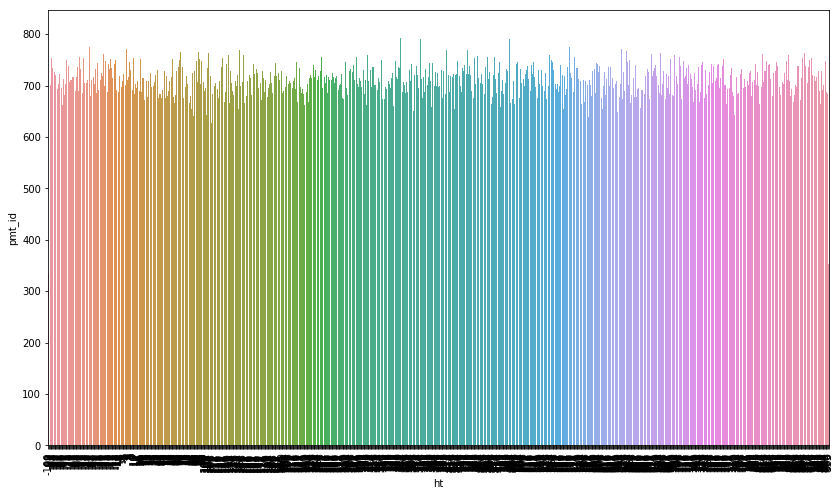

In [34]:
# Распределение времени отклика для шумовых событий в детекторах класса 1
plt.figure(figsize=(14,8))
sns.barplot(x="ht", y="pmt_id", data=gr11)
plt.xticks(rotation=90)
# Ну а шум как и положено по науке из равномерного распределния

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

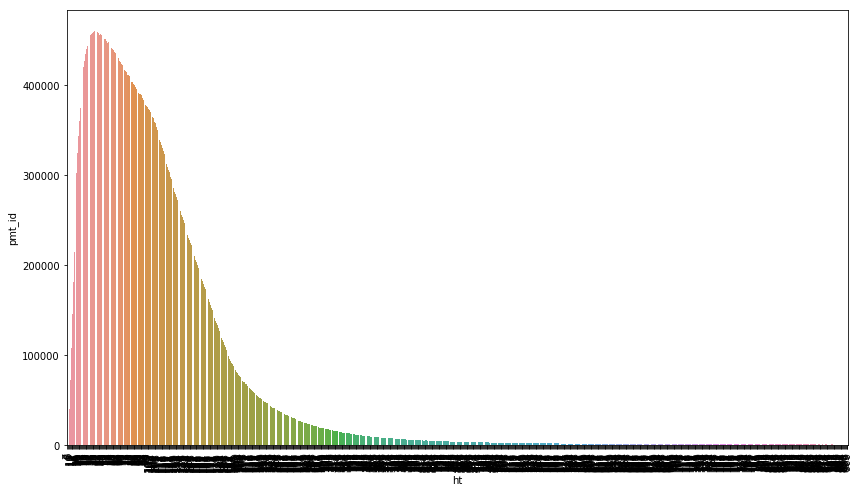

In [35]:
#Распределение времени отклика для нешумовых событий в детекторах класса 0
plt.figure(figsize=(14,8))
sns.barplot(x="ht", y="pmt_id", data=gr00)
plt.xticks(rotation=90)
# они приходят к нам из гамма распределения

(array([   0,    1,    2, ...,  998,  999, 1000]),
 <a list of 1001 Text xticklabel objects>)

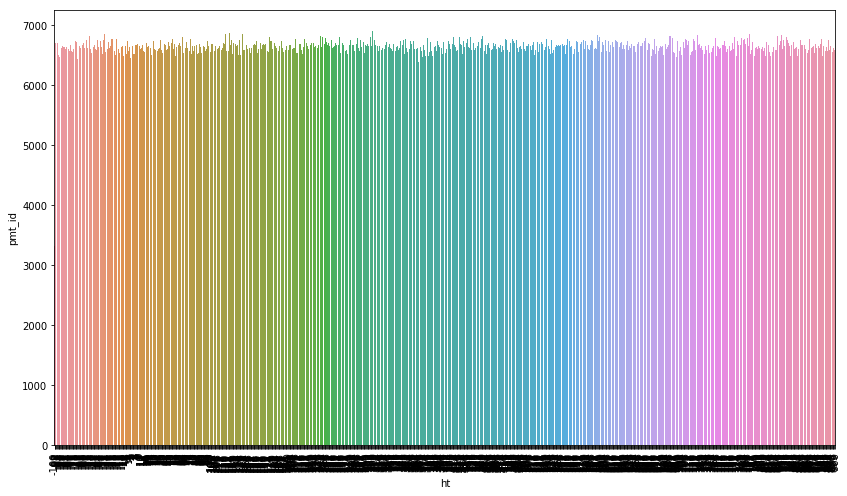

In [36]:
#Распределение времени отклика для нешумовых событий в детекторах класса 0
plt.figure(figsize=(14,8))
sns.barplot(x="ht", y="pmt_id", data=gr01)
plt.xticks(rotation=90)
# они приходят к нам из гамма распределения

In [44]:
# Для классификации шума можно использовать простой статистический критерий принадлежности значения гамма распределению:
# По номеру детектора мы можем определить кластер к которому принадлежит этот детектор,
# далее для этого кластера мы явно знаем распределение шума и не шума.
# Также можно возвращать вероятность шума, а далее чтобы выбрать threshold, мы можем реконсилировать все детекторы на общую ошибку (ведь мы знаем распределение средней ошибки для каждого кластера (2 нормальных горки))